# Dynamic Movement Primitives

#### This is an advanced tutorial on how to use extensions to Dynamic Movement Primitives package DMP. 

In [1]:
# To check the files of the parent folder
import sys, os, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
# Numpy package needed for DMP calculations
import numpy as np

# To visualize data
import matplotlib.pyplot as plt

# Dynamic Movement Primitives 
from DMP import DMP



## Create Trajectories

In [3]:
# Create trajectories to encode in DMP
data_length = 500
duration = 10.0

time = np.reshape(np.linspace(0, duration, num = data_length) , (data_length,1) )

# You can play around with the trajectories
x = np.cos(time)
y = -0.003*(time**3) -0.005*(time**2) +0.001*time
z = np.sin(0.5*time)+x +y

dataset = np.concatenate((time,x,y,z), axis = 1)

# Degrees of freedom for DMP ( 3 trajectories, 3 DoF here)
DoF = dataset[0,1:].shape[0]



## Learn Weights

In [4]:
# Choose the basis function number
bf_number = 20

# Choose the spring constant
K = 1000*np.ones(DoF) # Flexibility to set different K for different DoFs

# Initialize DMP and learn the weights
dmp = DMP(bf_number, K, 1, dataset)

# You can access the weights by 
weights = dmp.getWeights()

# Weight Matrix has a shape (bf_number*DoF) = (20*3)
# print weights


## Plot Basis Functions

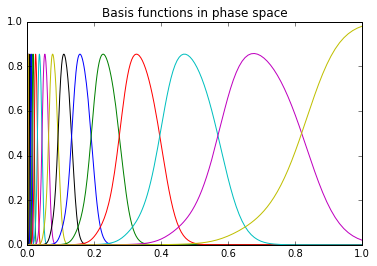

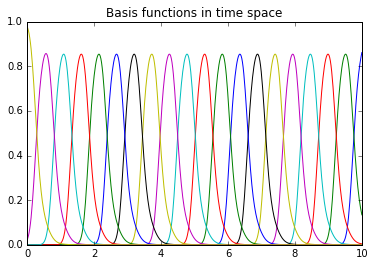

In [5]:
dmp.plot_basis_functions()

## Example 1 : Obstacle avoidance coupling term


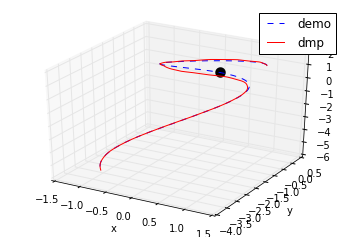

In [6]:
def axis_angle2rot(axis, angle):
    S = np.array([[0, -axis[2], axis[1]],
                  [axis[2], 0 , -axis[0]],
                  [-axis[1], axis[0], 0]
                     ])
    return np.eye(3) + np.sin(angle)*S + (1-np.cos(angle))*(np.outer(axis,axis)-np.eye(3))


# Set your desired duration
des_tau = duration

# Set your initial and goal parameters 
x0 = dataset[ 0,1:]  
g0 = dataset[-1,1:]


# Set delta time for numerical differentiation 
dt = duration/data_length

# Initialize current position and velocities ( e.g. move the arm to the initial position )
current_pos = x0 
current_vel = np.zeros(DoF)  # Initially the robot arm is at rest

# Create obstacle in the middle of movement (Ijspert et al 2013)
o = dataset[int(data_length/2), 1:]
gamma = 1000.
beta  = 20./np.pi

plot_position = np.zeros(3)
t = 0 
i = 0 ## burayi da duzelt
zeta = 0
while t <= des_tau : 
    if t > 0.1:
        # Calculate coupling term for obstacle
        theta = np.arccos((o-current_pos).dot(des_tau*current_vel)/ \
                          (np.linalg.norm(o-current_pos)*np.linalg.norm(des_tau*current_vel)))

        r     = np.cross((o-current_pos),des_tau*current_vel)
        R     = axis_angle2rot(r, np.pi/2)

        zeta  = gamma*theta*np.exp(-beta*theta)*R.dot(des_tau*current_vel)
    
    # Execute  DMP
    desired_pos, desired_vel  = dmp.executeDMP(t, dt, des_tau, x0, g0, current_pos,current_vel,zeta)
    
    # Execute the robot arm to the desired position with desired velocities
    current_pos = desired_pos
    current_vel = desired_vel
    

    # Store the current positions
    plot_position = np.row_stack((plot_position, current_pos))

    i += 1 ## plot_positiondan alabiliriz
    t += dt

%matplotlib inline
# If des_tau changed, plotting time may change
plot_time = np.linspace(0,des_tau, i) 

taskNames = ["Task x", "Task y", 'Task z']
DoF_names = ["x", "y", "z"]

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(dataset[:,1],dataset[:,2],dataset[:,3],linestyle='--',label = "demo")
ax.plot(plot_position[1:,0],plot_position[1:,1],plot_position[1:,2],color = 'r', label = 'dmp')
ax.scatter(o[0], o[1], o[2], lw = 6)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()



## Example 2 : Modulation at the velocity level -- limit position


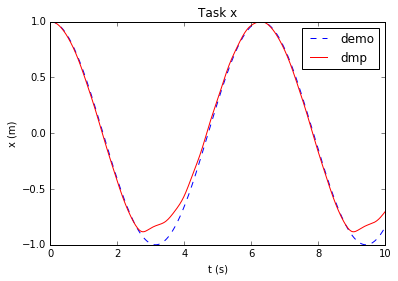

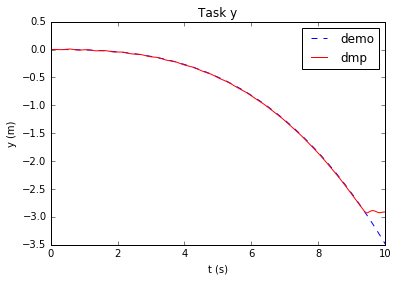

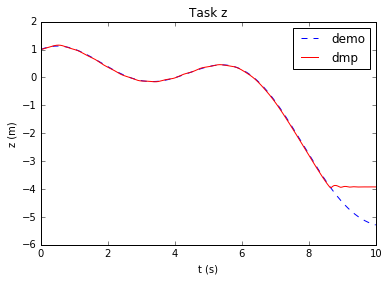

[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 2.00400802e-02  9.99799204e-01  1.80079115e-05  1.00983708e+00]
 [ 4.00801603e-02  9.99196898e-01  3.18549074e-05  1.01926749e+00]
 ...
 [ 9.95991984e+00 -8.60196285e-01 -3.45011234e+00 -5.27472458e+00]
 [ 9.97995992e+00 -8.49804544e-01 -3.47001809e+00 -5.28154103e+00]
 [ 1.00000000e+01 -8.39071529e-01 -3.49000000e+00 -5.28799580e+00]]


In [7]:
# Set your desired duration
des_tau = duration

# Set your initial and goal parameters 
x0 = dataset[ 0,1:]  
g0 = dataset[-1,1:]

# Set force feedback to zero for this example
zeta = 0 # force feedback at

# Set delta time for numerical differentiation 
dt = duration/data_length

# Initialize current position and velocities ( e.g. move the arm to the initial position )
current_pos = x0 
current_vel = np.zeros(DoF)  # Initially the robot arm is at rest

# Limit value (Gams et al 2013)
gamma = 1E2
lim   = np.array([-1, -3., -4.])

plot_position = np.zeros(3)
t = 0 
i = 0 ## burayi da duzelt
while t <= des_tau : 
    
    h = -1./(gamma*((lim-current_pos)**3))

    # Execute  DMP
    desired_pos, desired_vel  = dmp.executeDMP(t, dt, des_tau, x0, g0, current_pos,current_vel,zeta,h)
    
    # Execute the robot arm to the desired position with desired velocities
    current_pos = desired_pos
    current_vel = desired_vel
    
    # Store the current positions
    plot_position = np.row_stack((plot_position, current_pos))

    i += 1 ## plot_positiondan alabiliriz
    t += dt


# If des_tau changed, plotting time may change
plot_time = np.linspace(0,des_tau, i) 

taskNames = ["Task x", "Task y", 'Task z']
DoF_names = ["x", "y", "z"]
for i in range(DoF):
    plt.figure(taskNames[i])
    plt.plot(time,dataset[:,i+1],linestyle='--',label = "demo")
    plt.plot(plot_time,plot_position[1:,i],color = 'r', label = 'dmp')
    plt.title(taskNames[i])
    plt.ylabel(DoF_names[i]+" (m)")
    plt.xlabel("t (s)")
    plt.legend()
plt.show()
print dataset

## Example 3 : Hold current position in the middle of execution: comparison between with/without coupling term in terms of control commands and trajectory

Without coupling, DMP would continue its time evolution. It is undesirable since it can create dangerously large motor commands. See acceleration plots below for coupled DMP vs DMP.

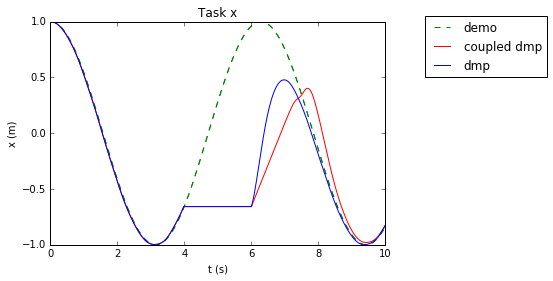

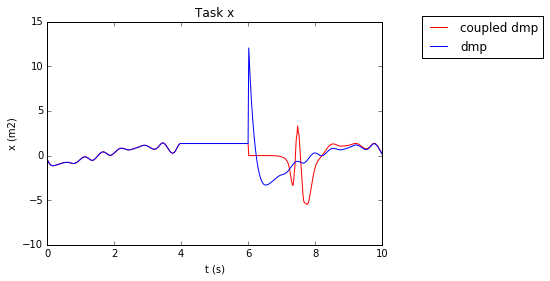

In [8]:
#----------------------------------------------- With Coupling ------------------------------------------------#    


from copy import deepcopy as dc
# Set your desired duration
des_tau = duration 

# Set your initial and goal parameters 
x0 = dc(dataset[ 0,1:]   )
g0 = dc(dataset[-1,1:] )

# Set force feedback to zero for this example
zeta = 0

# Set delta time for numerical differentiation 
dt = duration/data_length

# Initialize current position and velocities ( e.g. move the arm to the initial position )
current_pos = x0 
current_vel = np.zeros(DoF)  # Initially the robot arm is at rest
current_acc = np.zeros(DoF)  # Initially the robot arm is at rest


plot_position = np.zeros(3)
plot_acceleration = np.zeros(3)

t = 0 
i = 0
r = 0.09 #smoothing factor for low-pass filter
Kp = 1000
Kd = 125
alpha_e = 5.
Kt = 1E4
Kc = 1E8

e = 0.
filt_E = 0.
e_der = 0.
desired_pos = dc(current_pos)

while t <= duration :
    

    # Execute  DMP
    desired_pos, desired_vel  = dmp.executeDMP(t, dt, des_tau, x0, g0, current_pos,current_vel,zeta)
    

    # Perturbation
    if 4<=t <6: # Hold  current position for 1 second
        pass
    else:
        # Execute the robot arm to the desired position with desired velocities
        current_acc = (desired_vel-current_vel)/dt
        current_vel = desired_vel
        current_pos = desired_pos


    # Change des_tau and add coupling term to compensate for the perturbation
    e_der = alpha_e*(current_pos - desired_pos - e)
    e = desired_pos - current_pos
    filt_E = (1-r)*filt_E + r*e_der
    zeta = Kt*filt_E
    des_tau = duration + Kc*filt_E.dot(filt_E)
    
    # Store the current positions
    plot_position = np.row_stack((plot_position, current_pos))
    plot_acceleration = np.row_stack((plot_acceleration, current_acc))

    i += 1
    t += dt

# If des_tau changed, plotting time may change
plot_time = np.linspace(0,duration, i) 

taskNames = ["Task x", "Task y", 'Task z']
DoF_names = ["x", "y", "z"]
plt.ioff()
for i in [0]: #only one DoF of DMP is plotted for simplicity
    plt.figure(taskNames[i])
    plt.plot(time,dataset[:,1],linestyle='--',c = 'g',label = "demo")
    plt.plot(plot_time,plot_position[1:,i],color = 'r', label = 'coupled dmp')
    plt.title(taskNames[i])
    plt.ylabel(DoF_names[i]+" (m)")
    plt.xlabel("t (s)")
    plt.legend(bbox_to_anchor=(1.5, 1.05))

for i in [0]: #only one DoF of DMP is plotted for simplicity
    plt.figure("Acc")
    plt.plot(plot_time,plot_acceleration[1:,i],color = 'r', label = 'coupled dmp')
    plt.title(taskNames[i])
    plt.ylabel(DoF_names[i]+" (m)")
    plt.xlabel("t (s)")
    plt.legend(bbox_to_anchor=(1.5, 1.05))
    
    
#----------------------------------------------- No Coupling ------------------------------------------------#    
    
# Set your desired duration
des_tau = duration 

# Set your initial and goal parameters 
x0 = dc(dataset[ 0,1:]   )
g0 = dc(dataset[-1,1:] )

# Set force feedback to zero for this example
zeta = 0

# Set delta time for numerical differentiation 
dt = duration/data_length

# Initialize current position and velocities ( e.g. move the arm to the initial position )
current_pos = x0 
current_vel = np.zeros(DoF)  # Initially the robot arm is at rest
current_acc = np.zeros(DoF)  # Initially the robot arm is at rest


plot_position = np.zeros(3)
plot_acceleration = np.zeros(3)


t = 0 
i = 0

while t <= duration :
    

    # Execute  DMP
    desired_pos, desired_vel  = dmp.executeDMP(t, dt, des_tau, x0, g0, current_pos,current_vel,zeta)
    

    # Perturbation
    if 4<=t <6: # Hold  current position for 1 second
        pass
    else:
        # Execute the robot arm to the desired position with desired velocities
        current_acc = (desired_vel-current_vel)/dt
        current_vel = desired_vel
        current_pos = desired_pos

    
    # Store the current positions
    plot_position = np.row_stack((plot_position, current_pos))
    plot_acceleration = np.row_stack((plot_acceleration, current_acc))

    i += 1
    t += dt

# If des_tau changed, plotting time may change
plot_time = np.linspace(0,duration, i) 

taskNames = ["Task x", "Task y", 'Task z']
DoF_names = ["x", "y", "z"]
plt.ioff()
for i in [0]: #only one DoF of DMP is plotted for simplicity
    plt.figure(taskNames[i])
    plt.plot(time,dataset[:,1],linestyle='--', c = 'g')
    plt.plot(plot_time,plot_position[1:,i],color = 'b', label = 'dmp')
    plt.title(taskNames[i])
    plt.ylabel(DoF_names[i]+" (m)")
    plt.xlabel("t (s)")
    plt.legend(bbox_to_anchor=(1.5, 1.05))

for i in [0]: #only one DoF of DMP is plotted for simplicity
    plt.figure("Acc")
    plt.plot(plot_time,plot_acceleration[1:,i],color = 'b', label = 'dmp')
    plt.title(taskNames[i])
    plt.ylabel(DoF_names[i]+" (m2)")
    plt.xlabel("t (s)")
    plt.legend(bbox_to_anchor=(1.5, 1.05))
plt.show()